# Claudiane's dataset

In [1]:
#@title ## Setup: import libraries {display-mode: "form"}

import sys, os
from pathlib import Path  # file and directory paths in Python
import glob  # Unix style pathname pattern expansion
from datetime import datetime
import numpy as np  # large, multi-dimensional numeric arrays and matrices
import pandas as pd  # labelled tables with numeric and string data
import matplotlib  # data visualization
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # data visualization
import xarray as xr  # labelled multi-dimensional arrays
from tqdm.notebook import tqdm  # progress bar
from IPython.display import display, Math, Latex  # IPython formatting
import scipy as sp  # collection of mathematical algorithms and convenience functions built on NumPy
sys.path.insert(1, r'./../functions')
#from tnorma import tnorma
if os.getenv("COLAB_RELEASE_TAG"):
    !pip install -q ipywidgets  # Jupyter Widgets
    from google.colab import output
    output.enable_custom_widget_manager()

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' scipy {sp.__version__}', f' pandas {pd.__version__}',
      datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0] on linux
 numpy 2.2.3
 scipy 1.15.2
 pandas 2.2.3
20/02/2025 13:17:35


In [2]:
#@title ## Helping funcions {display-mode: "form"}

def tnorma(y, axis=0, step=1, k=3, smooth=0, mask=None, nan_at_ext='delete',
           show=False, ax=None):
    """Temporal normalization (from 0 to 100% with step interval).
    Temporal normalization is usually employed for the temporal alignment of
    data obtained from different trials with different duration (number of
    points). This code implements a procedure knwown as the normalization to
    percent cycle.

    This code can perform simple linear interpolation passing through each
    datum or spline interpolation (up to quintic splines) passing through each
    datum (knots) or not (in case a smoothing parameter > 0 is inputted).

    NaNs and any value inputted as a mask parameter and that appears at the
    extremities might be removed or replaced by the first/last not-NaN value
    before the interpolation because this code does not perform extrapolation.
    For a 2D array, the entire row with NaN or a mask value at the extermity
    might be removed because of alignment issues with the data from different
    columns. As result, if there is a column of only NaNs in the data, the
    temporal normalization can't be performed (an empty NaNs and any value
    inputted as a mask parameter and that appears in the middle of the data
    (which may represent missing data) are ignored and the interpolation is
    performed through these points.

    See this IPython notebook [2]_.

    Parameters
    ----------
    y : 1-D or 2-D array_like
        Array of independent input data. Must be increasing.
        If 2-D array, the data in each axis will be interpolated.
    axis : int, 0 or 1, optional (default = 0)
        Axis along which the interpolation is performed.
        0: data in each column are interpolated; 1: for row interpolation
    step : float or int, optional (default = 1)
        Interval from 0 to 100% to resample y or the number of points y
        should be interpolated. In the later case, the desired number of
        points should be expressed with step as a negative integer.
        For instance, step = 1 or step = -101 will result in the same
        number of points at the interpolation (101 points).
        If step == 0, the number of points will be the number of data in y.
    k : int, optional (default = 3)
        Degree of the smoothing spline. Must be 1 <= k <= 5.
        If 3, a cubic spline is used.
        The number of data points must be larger than k.
    smooth : float or None, optional (default = 0)
        Positive smoothing factor used to choose the number of knots.
        If 0, spline will interpolate through all data points.
        If None, smooth=len(y).
    mask : None or float, optional (default = None)
        Mask to identify missing values which will be ignored.
        It can be a list of values.
        NaN values will be ignored and don't need to be in the mask.
    nan_at_ext : string, optional (default = 'delete')
        Method to deal with NaNs at the extremities.
        'delete' will delete any NaN at the extremities (the corresponding
        entire row in `y` for a 2-D array).
        'replace' will replace any NaN at the extremities by first/last
        not-NaN value in `y`.
    show : bool, optional (default = False)
        True (1) plot data in a matplotlib figure.
        False (0) to not plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    yn : 1-D or 2-D array
        Interpolated data (if axis == 0, column oriented for 2-D array).
    tn : 1-D array
        New x values (from 0 to 100) for the interpolated data.
    inds : list
        Indexes of first and last rows without NaNs at the extremities of `y`.
        If there is no NaN in the data, this list is [0, y.shape[0]-1].

    Notes
    -----
    This code performs interpolation to create data with the desired number of
    points using a one-dimensional smoothing spline fit to a given set of data
    points (scipy.interpolate.UnivariateSpline function).

    References
    ----------
    .. [1] http://www.sciencedirect.com/science/article/pii/S0021929010005038
    .. [2] https://github.com/demotu/psd2/blob/master/docs/tnorma.ipynb

    See Also
    --------
    scipy.interpolate.UnivariateSpline:
    One-dimensional smoothing spline fit to a given set of data points.

    Examples
    --------
    >>> # Default options: cubic spline interpolation passing through
    >>> # each datum, 101 points, and no plot
    >>> y = [5,  4, 10,  8,  1, 10,  2,  7,  1,  3]
    >>> tnorma(y)

    >>> # Linear interpolation passing through each datum
    >>> y = [5,  4, 10,  8,  1, 10,  2,  7,  1,  3]
    >>> yn, tn, indie = tnorma(y, k=1, smooth=0, mask=None, show=True)

    >>> # Cubic spline interpolation with smoothing
    >>> y = [5,  4, 10,  8,  1, 10,  2,  7,  1,  3]
    >>> yn, tn, indie = tnorma(y, k=3, smooth=1, mask=None, show=True)

    >>> # Cubic spline interpolation with smoothing and 50 points
    >>> x = np.linspace(-3, 3, 100)
    >>> y = np.exp(-x**2) + np.random.randn(100)/10
    >>> yn, tn, indie = tnorma(y, step=-50, k=3, smooth=1, show=True)

    >>> # Deal with missing data (use NaN as mask)
    >>> x = np.linspace(-3, 3, 100)
    >>> y = np.exp(-x**2) + np.random.randn(100)/10
    >>> y[:10] = np.NaN # first ten points are missing
    >>> y[30: 41] = np.NaN # make other 10 missing points
    >>> yn, tn, indie = tnorma(y, step=-50, k=3, smooth=1, show=True)

    >>> # Deal with missing data at the extremities replacing by first/last not-NaN
    >>> x = np.linspace(-3, 3, 100)
    >>> y = np.exp(-x**2) + np.random.randn(100)/10
    >>> y[0:10] = np.NaN # first ten points are missing
    >>> y[-10:] = np.NaN # last ten points are missing
    >>> yn, tn, indie = tnorma(y, step=-50, k=3, smooth=1, nan_at_ext='replace', show=True)

    >>> # Deal with missing data at the extremities replacing by first/last not-NaN
    >>> x = np.linspace(-3, 3, 100)
    >>> y = np.exp(-x**2) + np.random.randn(100)/10
    >>> y[0:10] = np.NaN # first ten points are missing
    >>> y[-10:] = np.NaN # last ten points are missing
    >>> yn, tn, indie = tnorma(y, step=-50, k=1, smooth=0, nan_at_ext='replace', show=True)

    >>> # Deal with 2-D array
    >>> x = np.linspace(-3, 3, 100)
    >>> y = np.exp(-x**2) + np.random.randn(100)/10
    >>> y = np.vstack((y-1, y[::-1])).T
    >>> yn, tn, indie = tnorma(y, step=-50, k=3, smooth=1, show=True)

    Version history
    ---------------
    '0.0.3':
        Docs
    """

    from scipy.interpolate import UnivariateSpline

    y = np.asarray(y)
    if axis:
        y = y.T
    if y.ndim == 1:
        y = np.reshape(y, (-1, 1))
    # turn mask into NaN
    if mask is not None:
        y[y == mask] = np.nan

    iini = 0
    iend = y.shape[0]-1
    if nan_at_ext.lower() == 'delete':
        # delete rows with missing values at the extremities
        while y.size and np.isnan(np.sum(y[0])):
            y = np.delete(y, 0, axis=0)
            iini += 1
        while y.size and np.isnan(np.sum(y[-1])):
            y = np.delete(y, -1, axis=0)
            iend -= 1
    else:
        # replace NaN at the extremities by first/last not-NaN
        if np.any(np.isnan(y[0])):
            for col in range(y.shape[1]):
                ind_not_nan = np.nonzero(~np.isnan(y[:, col]))[0]
                if ind_not_nan.size:
                    y[0, col] = y[ind_not_nan[0], col]
                else:
                    y = np.empty((0, 0))
                    break
        if np.any(np.isnan(y[-1])):
            for col in range(y.shape[1]):
                ind_not_nan = np.nonzero(~np.isnan(y[:, col]))[0]
                if ind_not_nan.size:
                    y[-1, col] = y[ind_not_nan[-1], col]
                else:
                    y = np.empty((0, 0))
                    break

    # check if there are still data
    if not y.size:
        return np.empty((0, 0)), np.empty(0), []
    if y.size == 1:
        return y.flatten(), np.array(0), [0, 0]

    indie = [iini, iend]

    t = np.linspace(0, 100, y.shape[0])
    if step == 0:
        tn = t
    elif step > 0:
        tn = np.linspace(0, 100, int(np.round(100 / step + 1)))
    else:
        tn = np.linspace(0, 100, -step)
    yn = np.empty([tn.size, y.shape[1]]) * np.nan
    for col in np.arange(y.shape[1]):
        # ignore NaNs inside data for the interpolation
        ind = np.isfinite(y[:, col])
        if np.sum(ind) > 1:  # at least two points for the interpolation
            spl = UnivariateSpline(t[ind], y[ind, col], k=k, s=smooth)
            yn[:, col] = spl(tn)

    if show:
        _plot(t, y, ax, tn, yn)

    if axis:
        y = y.T
    if yn.shape[1] == 1:
        yn = yn.flatten()

    return yn, tn, indie



def _plot(t, y, ax, tn, yn):
    """Plot results of the tnorma function, see its help."""
    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, ax = plt.subplots(1, 1, figsize=(8, 5))

        ax.set_prop_cycle('color', ['b', 'r', 'b', 'g', 'b', 'y', 'b', 'c', 'b', 'm'])
        #ax.set_color_cycle(['b', 'r', 'b', 'g', 'b', 'y', 'b', 'c', 'b', 'm'])
        for col in np.arange(y.shape[1]):
            if y.shape[1] == 1:
                ax.plot(t, y[:, col], 'o-', lw=1, label='Original data')
                ax.plot(tn, yn[:, col], '.-', lw=2,
                        label='Interpolated')
            else:
                ax.plot(t, y[:, col], 'o-', lw=1)
                ax.plot(tn, yn[:, col], '.-', lw=2, label='Col= %d' % col)
            ax.locator_params(axis='y', nbins=7)
            ax.legend(fontsize=12, loc='best', framealpha=.5, numpoints=1)
        plt.xlabel('[%]')
        plt.tight_layout()
        plt.show()

In [3]:
path2 = Path('./../../X/WBDS')

fnames = glob.glob(path2.as_posix() + os.sep + 'WBDSascii' + os.sep + '*.txt*')
print(path2)
print(f'Number of files in dataset: {len(fnames)}')

../../X/WBDS
Number of files in dataset: 4896


## Metadata

In [8]:
info = pd.read_excel(path2.as_posix() + os.sep + 'WBDSinfo.xlsx', na_values='--')
info = info[['FileName', 'Subject', 'AgeGroup', 'Age',	'Height', 'Mass', 'Gender', 'Dominance', 'LegLength', 'GaitSpeed(m/s)']]
#info = info[info['Subject'].isin(subs2)].drop_duplicates(subset='Subject', ignore_index=True)
info.Height = info.Height/100
# Comfortable speed data
cspeed = info[info['FileName'].str.contains('C.c3d')]
cspeed = cspeed[['Subject', 'GaitSpeed(m/s)']].groupby('Subject').mean()
display(cspeed)

info = info.drop_duplicates(subset='Subject', ignore_index=True)
# files of subject 7 are named wrongly (S03), fix that:
info.iat[6, 0] = 'WBDS07walkT01ang.txt'	

info[['Age', 'Height', 'Mass', 'LegLength']].describe()

/home/marcos/miniconda3/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,GaitSpeed(m/s)
Subject,
1,1.221765
2,1.237143
3,0.961250
4,1.286667
5,1.252143
6,1.320714
7,1.110000
8,1.335000
9,1.160000


,Age,Height,Mass,LegLength
count,42.000000,42.000000,42.000000,42.000000
mean,42.642857,1.671190,67.764286,0.860476
std,18.627048,0.110141,11.242674,0.067280
min,21.000000,1.470000,44.900000,0.710000
25%,25.750000,1.576250,61.312500,0.812500
50%,32.500000,1.681000,68.525000,0.863750
75%,60.500000,1.739000,75.462500,0.905000
max,84.000000,1.920000,95.400000,0.980000


## Trials overground at comfortable speed

In [19]:
variables = ['Pelvis_X', 'Pelvis_Y', 'Pelvis_Z', 'Hip_X', 'Hip_Y', 'Hip_Z', 'Knee_Z', 'Ankle_Z', 'Foot_Y',
             'HipMoment_Z', 'KneeMoment_Z', 'AnkleMoment_Z', 'SupportMoment_Z']

data = np.full(shape=(51, len(variables), info.shape[0]), fill_value=np.nan)
for subject in tqdm(range(0, data.shape[-1])):
    if os.path.isfile(fname:= path2.as_posix() + os.sep + 'WBDSascii' + os.sep + f'WBDS{subject+1:02}walkOCang.txt'):
        #y = np.loadtxt(fname, delimiter='\t', skiprows=1)
        df = pd.read_csv(fname, delimiter='\t')
        df['PelvisAngleY'] = df[['RPelvisAngleX', 'LPelvisAngleX']].mean(axis=1)
        df['PelvisAngleZ'] = df[['RPelvisAngleY', 'LPelvisAngleY']].mean(axis=1)
        df['PelvisAngleX'] = df[['RPelvisAngleZ', 'LPelvisAngleZ']].mean(axis=1)
        df['HipAngleY'] = df[['RHipAngleX', 'LHipAngleX']].mean(axis=1)
        df['HipAngleZ'] = df[['RHipAngleY', 'LHipAngleY']].mean(axis=1)
        df['HipAngleX'] = df[['RHipAngleZ', 'LHipAngleZ']].mean(axis=1)
        df['KneeAngleZ'] = df[['RKneeAngleZ', 'LKneeAngleZ']].mean(axis=1)
        df['AnkleAngleZ'] = df[['RAnkleAngleZ', 'LAnkleAngleZ']].mean(axis=1)
        df['FootAngleY'] = df[['RFootAngleY', 'LFootAngleY']].mean(axis=1) 
        y = df[['PelvisAngleX', 'PelvisAngleY', 'PelvisAngleZ',
                'HipAngleX', 'HipAngleY', 'HipAngleZ',
                'KneeAngleZ', 'AnkleAngleZ', 'FootAngleY']].values
    else:
        print(f'{fname} does not exist')
    if os.path.isfile(fname:= path2.as_posix() + os.sep + 'WBDSascii' + os.sep + f'WBDS{subject+1:02}walkOCknt.txt'):
        df = pd.read_csv(fname, delimiter='\t')
        df['HipMomentZ'] = -df[['RHipMomentZ', 'LHipMomentZ']].mean(axis=1)
        df['KneeMomentZ'] = df[['RKneeMomentZ', 'LKneeMomentZ']].mean(axis=1)
        df['AnkleMomentZ'] = df[['RAnkleMomentZ', 'LAnkleMomentZ']].mean(axis=1)
        df['SupportMomentZ'] = df[['HipMomentZ', 'KneeMomentZ', 'AnkleMomentZ']].sum(axis=1)
        y = np.c_[y, df[['HipMomentZ', 'KneeMomentZ', 'AnkleMomentZ', 'SupportMomentZ']].values]
    else:
        print(f'{fname} does not exist')

    data[:, :, subject], tn, indie = tnorma(y, step=2, k=3, smooth=0, mask=None, show=False)

np.save(file=path2/'angles_mom_all_ref_claudiane.npy', arr=data)
dados_m  = np.nanmean(data, axis=2)
dados_sd = np.nanstd(data, axis=2, ddof=1)
dados = np.empty(shape=(51, int((data.shape[1]*2)))) * np.nan
dados[:, ::2] = dados_m
dados[:, 1::2] = dados_sd
variables = [f'{var}_{msd}' for var in variables for msd in ['m', 'sd']]
dados = pd.DataFrame(data=dados, index=np.arange(0, 102, 2), columns=variables)
dados.to_csv(path2 / 'angles_mom_ref_claudiane.csv', index=True)

np.save(file=path2/'angles_mom_all_ref_claudiane.npy', arr=data)

  0%|          | 0/42 [00:00<?, ?it/s]

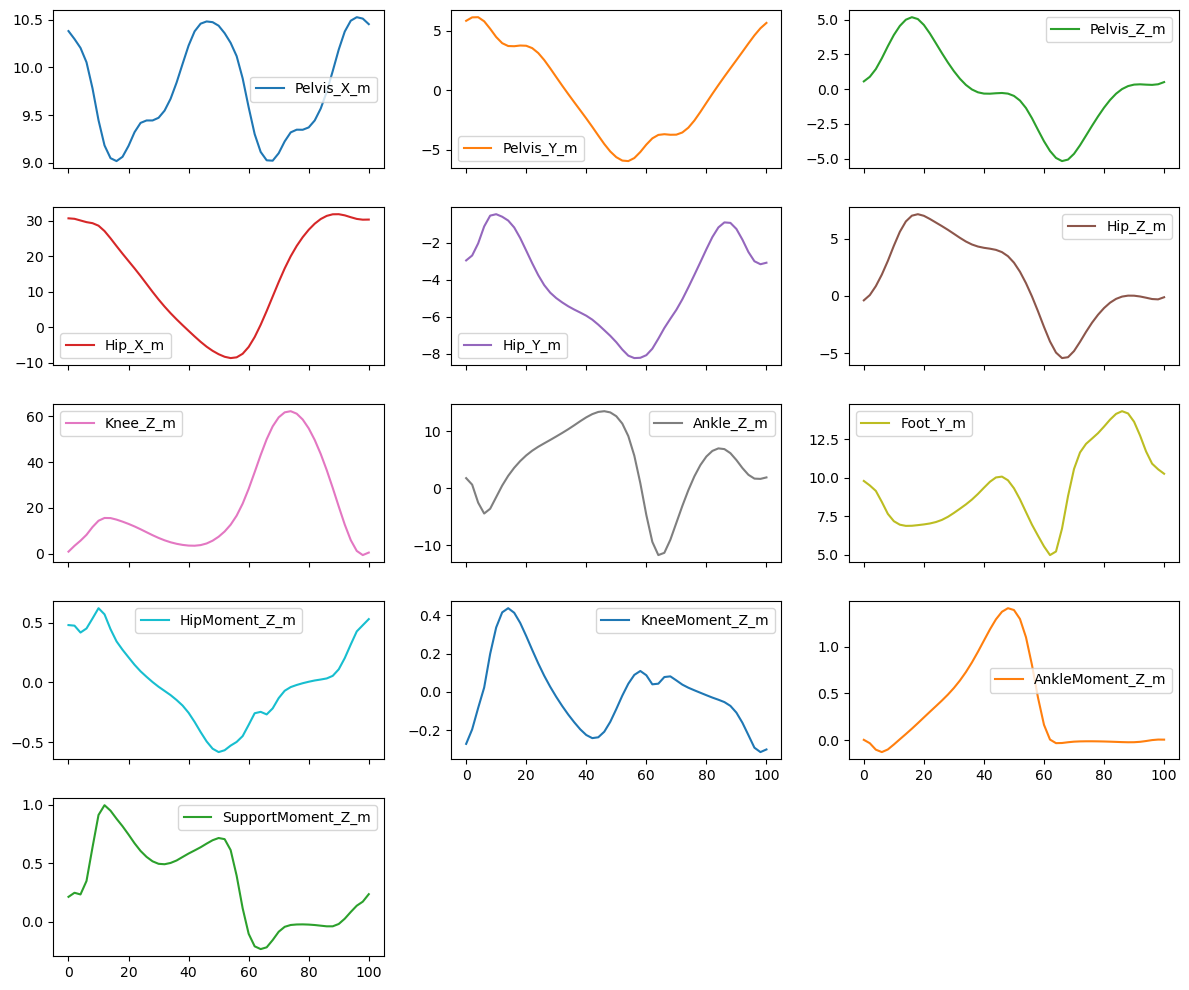

In [16]:
dados.plot(y=dados.columns[::2], kind='line', subplots=True, layout=(5, 3), figsize=(12, 10))
plt.tight_layout()
plt.show()

## Trials on the treadmill

In [ ]:
# 'ang' and 'knt' rows don't have gait speed, fix that
# fnames_c3d = info[info['FileName'].str.contains(r'grf.txt')]['FileName']
# for fname in tqdm(fnames_grf):
#     value = info[info['FileName'] == fname]['GaitSpeed(m/s)'].values[0]
#     if not (row := info[info['FileName'] == fname[:-7] + 'ang.txt'].index).empty:
#         info.loc[row, 'GaitSpeed(m/s)'] = value
#     if not (row := info[info['FileName'] == fname[:-7] + 'knt.txt'].index).empty:
#         info.loc[row, 'GaitSpeed(m/s)'] = value
# filter only the rows with 'ang' info
infot = info[info['FileName'].str.contains('ang')]  # |knt
infot = infot[infot['FileName'].str.contains('T', case=True)]
# Speed: '01' to '08': 40%, 55%, 70%, 85%, 100%, 115%, 130%, 145% of the self-selected, dimensionless speed (Froude number)
infot

In [ ]:
cols = ['Time',
        'RPelvisAngleX', 'RPelvisAngleY', 'RPelvisAngleZ', 'LPelvisAngleX', 'LPelvisAngleY', 'LPelvisAngleZ',
        'RHipAngleX', 'RHipAngleY', 'RHipAngleZ', 'LHipAngleX', 'LHipAngleY', 'LHipAngleZ',
        'RKneeAngleX', 'RKneeAngleY', 'RKneeAngleZ', 'LKneeAngleX', 'LKneeAngleY', 'LKneeAngleZ',
        'RAnkleAngleX', 'RAnkleAngleY', 'RAnkleAngleZ', 'LAnkleAngleX', 'LAnkleAngleY', 'LAnkleAngleZ',
        'RFootAngleX', 'RFootAngleY', 'RFootAngleZ', 'LFootAngleX', 'LFootAngleY', 'LFootAngleZ']

data = np.full(shape=(101, 9, 8, info.shape[0]), fill_value=np.nan)
for subject in range(0, 42):
    for speed in range(0, 8):
        if os.path.isfile(fname:= path2.as_posix() + os.sep + 'WBDSascii' + os.sep + f'WBDS{subject+1:02}walkT{speed+1:02}ang.txt'):
            #y = np.loadtxt(fname, delimiter='\t', skiprows=1)
            df = pd.read_csv(fname, delimiter='\t')
            df['PelvisAngleZ'] = df[['RPelvisAngleX', 'LPelvisAngleX']].mean(axis=1)
            df['PelvisAngleY'] = df[['RPelvisAngleY', 'LPelvisAngleY']].mean(axis=1)
            df['PelvisAngleX'] = df[['RPelvisAngleZ', 'LPelvisAngleZ']].mean(axis=1)
            df['HipAngleZ'] = df[['RHipAngleX', 'LHipAngleX']].mean(axis=1)
            df['HipAngleY'] = df[['RHipAngleY', 'LHipAngleY']].mean(axis=1)
            df['HipAngleX'] = df[['RHipAngleZ', 'LHipAngleZ']].mean(axis=1)
            df['KneeAngleZ'] = df[['RKneeAngleZ', 'LKneeAngleZ']].mean(axis=1)
            df['AnkleAngleZ'] = df[['RAnkleAngleZ', 'LAnkleAngleZ']].mean(axis=1)
            df['FootAngleY'] = df[['RFootAngleY', 'LFootAngleY']].mean(axis=1) 
            data[:, :, speed, subject] = df[['PelvisAngleX', 'PelvisAngleY', 'PelvisAngleZ', 'HipAngleX',
                                             'HipAngleY', 'HipAngleZ', 'KneeAngleZ', 'AnkleAngleZ', 'FootAngleY']].values
        else:
            print(f'{fname} does not exist')